# Microproyecto: Alcanzando los objetivos de desarrollo sostenible. Un aporte desde el machine learning

Este proyecto tiene como objetivo desarrollar una solución, basada en técnicas de procesamiento de lenguaje natural y machine learning, que facilite la interpretación y análisis de información textual para la identificación de relaciones semánticas con los Objetivos de Desarrollo Sostenibles.

Para cumplir con el objetivo fue necesario:


*   Preparar los datos, eliminar signos de puntuaciòn, eliminar stop words, convertir todo el texto a minúsculas
*   Desarrollar un modelo de clasificación para relacionar un texto con un ODS
*   Evaluar el modelo

#### Paquetes

Previo a todo desarrollo de código, es necesario importar los módulos de python a usar. Para cumplir los objetivos se hara uso de una amplia gama de paquetes, en la siguiente celda de código se importan etsos paquetes.

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

from nltk import download
download("stopwords")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Preprocesamiento

Inicialmente se carga el csv con los textos y su ODS correspondiente:

In [ ]:
raw_data = pd.read_csv("Train_textosODS.csv", sep=";", encoding='latin-1')
raw_data.shape

(9656, 2)

Se eliminan datos nulos y duplicados:

In [ ]:
data = raw_data.copy()
data.dropna(inplace=True)
data.drop_duplicates(inplace=True)
data.shape

(9656, 2)

Notamos que no habian datos nulos ni duplicados, procedemos a separar las caracterizticas y su respectiva etiqueta. Ademas separamos los datos de entrenamiento y de test para validacion:

In [ ]:
X, y = data["textos"], data["ODS"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Finalmente definimos la clase TextProcessor para ejecutar el preprocesado de los datos, en este caso nos permitimos tokenizar las palabras con un word_tokenize simple o uno personalizado a travex de RegexpTokenizer. Ademas, la clase permite la eliminacion de palabras stop y hacer stem.

In [ ]:
class TextProcessor:

    nltk = __import__("nltk")
    np = __import__("numpy")

    def __init__(self, process):

        Regex = self.nltk.RegexpTokenizer(r'\w+')
        simple = self.nltk.tokenize.word_tokenize
        stop = self.nltk.corpus.stopwords.words("spanish")
        stemmer = self.nltk.stem.PorterStemmer()

        self.process = process
        self.transform = {"simple": lambda x: simple(x),
                          "personalized": lambda x: Regex.tokenize(x),
                          "stop": lambda x: [token for token in x if token not in stop],
                          "stemme": lambda x: [stemmer.stem(token) for token in x]}

    def get_mean_vector(self, words):
        model = self.w2v
        mean = self.np.mean([model.wv[word] for word in words if word in self.w2v.wv], axis=0)
        return mean if mean is not None else self.np.zeros(100)

    def textProcess(self, text):
        text = text.lower()
        for step in self.process:
            text = self.transform[step](text)
        return ' '.join(map(str, text))

## Clasificador

Se define la clase Classifier que crea un pipeline con las instrucciones indicadas, permitiendo la seleccion del vectorizador (este vectorizador implementa el preprocesado previamente definido) y el clasificador a usar, ademas de generar un score (se usan metricas de accuracy y f1 debido a que es un problema de clasificacion) del modelo.

In [ ]:
class Classifier:
    sk = __import__("sklearn")

    def __init__(self, textProcessor: TextProcessor, process, params):
        self.processor = textProcessor(process["steps"])
        self.pipeline = self.get_pipeline(process, params)

    def get_clf(self, model, clf):
        model = getattr(self.sk, model)
        classifier = getattr(model, clf)
        return classifier

    def get_pipeline(self, process, params):

        vectorizer = getattr(self.sk.feature_extraction.text, process["vectorizer"])
        dim_red = self.sk.decomposition.TruncatedSVD(params["dimred"])
        clf = self.get_clf(**process["clf"])(**params["clf"])

        steps = (("vectorizer", vectorizer(preprocessor = self.processor.textProcess)),
                 ("dimred", dim_red),
                 ("clf", clf))

        pipeline = self.sk.pipeline.Pipeline(steps)
        return pipeline

    def fit(self, X, y = None):
        self.pipeline.fit(X, y)

    def predict(self, X):
        return self.pipeline.predict(X)

    def classification_report(self, X, y):
        y_pred = self.predict(X)
        print(self.sk.metrics.classification_report(y, y_pred))

    def accuracy_score(self, X, y):
        y_pred = self.predict(X)
        return self.sk.metrics.accuracy_score(y, y_pred)

    def f1_score(self, X, y):
        y_pred = self.predict(X)
        return self.sk.metrics.f1_score(y, y_pred, average='macro')

Probamos el algoritmo para algunos vectorizadores y modelos:

In [ ]:
process = {"steps": ("personalized", "stop", "stemme"),
           "vectorizer": "CountVectorizer",
           "dimred": "TruncatedSVD",
           "clf":{"model": "linear_model",
                  "clf": "LogisticRegression"}}

params = {"dimred": 100,
          "clf": {"penalty": "l2",
                 "C": 0.1}}

clf = Classifier(TextProcessor, process, params)
clf.fit(X_train, y_train)
clf.classification_report(X_test, y_test)

              precision    recall  f1-score   support

           1       0.79      0.79      0.79        90
           2       0.64      0.66      0.65        71
           3       0.84      0.87      0.85       178
           4       0.91      0.96      0.93       200
           5       0.95      0.88      0.92       232
           6       0.92      0.90      0.91       135
           7       0.85      0.84      0.84       164
           8       0.56      0.60      0.58        86
           9       0.55      0.67      0.61        55
          10       0.56      0.48      0.52        60
          11       0.83      0.72      0.77       143
          12       0.70      0.78      0.74        64
          13       0.82      0.77      0.80       102
          14       0.75      0.75      0.75        64
          15       0.83      0.77      0.79        81
          16       0.92      0.98      0.95       207

    accuracy                           0.82      1932
   macro avg       0.78   

In [ ]:
process = {"steps": ("personalized", "stop", "stemme"),
           "vectorizer": "TfidfVectorizer",
           "dimred": "TruncatedSVD",
           "clf":{"model": "linear_model",
                  "clf": "LogisticRegression"}}

params = {"dimred": 100,
          "clf": {"penalty": "l2",
                 "C": 0.1}}

clf = Classifier(TextProcessor, process, params)
clf.fit(X_train, y_train)
clf.classification_report(X_test, y_test)

              precision    recall  f1-score   support

           1       0.85      0.69      0.76        90
           2       0.86      0.25      0.39        71
           3       0.58      0.88      0.70       178
           4       0.65      0.99      0.78       200
           5       0.83      0.92      0.88       232
           6       0.88      0.91      0.90       135
           7       0.69      0.94      0.80       164
           8       0.89      0.20      0.32        86
           9       0.00      0.00      0.00        55
          10       0.73      0.13      0.23        60
          11       0.93      0.54      0.68       143
          12       1.00      0.12      0.22        64
          13       0.91      0.62      0.74       102
          14       1.00      0.33      0.49        64
          15       1.00      0.16      0.28        81
          16       0.49      0.99      0.66       207

    accuracy                           0.69      1932
   macro avg       0.77   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
process = {"steps": ("personalized", "stop", "stemme"),
           "vectorizer": "CountVectorizer",
           "dimred": "TruncatedSVD",
           "clf":{"model": "svm",
                  "clf": "LinearSVC"}}

params = {"dimred": 100,
          "clf": {"penalty": "l2",
                 "C": 0.1}}

clf = Classifier(TextProcessor, process, params)
clf.fit(X_train, y_train)
clf.classification_report(X_test, y_test)

              precision    recall  f1-score   support

           1       0.78      0.80      0.79        90
           2       0.65      0.72      0.68        71
           3       0.83      0.87      0.85       178
           4       0.89      0.97      0.93       200
           5       0.94      0.89      0.91       232
           6       0.90      0.89      0.90       135
           7       0.86      0.81      0.84       164
           8       0.62      0.55      0.58        86
           9       0.56      0.64      0.59        55
          10       0.57      0.50      0.53        60
          11       0.82      0.72      0.77       143
          12       0.66      0.72      0.69        64
          13       0.78      0.79      0.79       102
          14       0.85      0.72      0.78        64
          15       0.82      0.80      0.81        81
          16       0.91      0.99      0.95       207

    accuracy                           0.82      1932
   macro avg       0.78   

La flexibilidad del clasificador permite trabajar tambien con modelos no supervisados como clustering, en este caso notamos que una clasificacion a traves de k-means no presenta un buen desempeño:

In [ ]:
process = {"steps": ("personalized", "stop", "stemme"),
           "vectorizer": "CountVectorizer",
           "dimred": "TruncatedSVD",
           "clf":{"model": "cluster",
                  "clf": "KMeans"}}

params = {"dimred": 100,
          "clf": {"n_clusters": 16}}

clf = Classifier(TextProcessor, process, params)
clf.fit(X_train)
clf.classification_report(X_test, y_test)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00        90
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00       178
           4       0.00      0.00      0.00       200
           5       0.07      0.02      0.03       232
           6       0.00      0.00      0.00       135
           7       0.00      0.00      0.00       164
           8       0.00      0.00      0.00        86
           9       0.00      0.00      0.00        55
          10       0.02      0.02      0.02        60
          11       0.08      0.06      0.07       143
          12       0.00      0.00      0.00        64
          13       0.02      0.01      0.01       102
          14       0.00      0.00      0.00        64
          15       0.00      0.00      0.00        81
          16       0.00      0.00      0.00       207

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

In [ ]:
clf.classification_report(X_test, y_test.values)

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00        90
           2       0.00      0.00      0.00        71
           3       0.00      0.00      0.00       178
           4       0.00      0.00      0.00       200
           5       0.07      0.02      0.03       232
           6       0.00      0.00      0.00       135
           7       0.00      0.00      0.00       164
           8       0.00      0.00      0.00        86
           9       0.00      0.00      0.00        55
          10       0.02      0.02      0.02        60
          11       0.08      0.06      0.07       143
          12       0.00      0.00      0.00        64
          13       0.02      0.01      0.01       102
          14       0.00      0.00      0.00        64
          15       0.00      0.00      0.00        81
          16       0.00      0.00      0.00       207

    accuracy              

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_

### Word2Vec

Como componente adicional podemos evaluar el desempeño usando un preprocesado con word2vec. Notamos que es inferior en el desempeño general:

In [ ]:
import numpy as np
from gensim.models import Word2Vec
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report

# Preprocesamiento adicional para Word2Vec
textos = raw_data['textos'].apply(lambda x: x.split())

# Entrenamiento del modelo Word2Vec
w2v_model = Word2Vec(textos, vector_size=100, window=5, min_count=1)

# Obtener vectores promedio para cada texto
def get_mean_vector(words, model):
    return np.mean([model.wv[word] for word in words if word in model.wv], axis=0)

X_w2v = textos.apply(lambda x: get_mean_vector(x, w2v_model))
X_w2v = list(X_w2v)

# Convertir a matriz numpy y manejar posibles NaNs
X_w2v = np.array([vec if vec is not None else np.zeros(100) for vec in X_w2v])

# Codificar etiquetas si es necesario
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# División y entrenamiento similares a los pasos anteriores
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y_encoded, test_size=0.2, random_state=42)

# Entrenamiento del modelo
modelo_w2v = LinearSVC(random_state=42)
modelo_w2v.fit(X_train_w2v, y_train_w2v)

# Evaluación del modelo
y_pred_w2v = modelo_w2v.predict(X_test_w2v)
print("\nReporte de clasificación con Word2Vec:")
print(classification_report(y_test_w2v, y_pred_w2v))


Reporte de clasificación con Word2Vec:
              precision    recall  f1-score   support

           0       0.57      0.62      0.59        90
           1       0.20      0.01      0.03        71
           2       0.57      0.72      0.63       178
           3       0.58      0.89      0.70       200
           4       0.75      0.88      0.81       232
           5       0.62      0.81      0.70       135
           6       0.46      0.76      0.57       164
           7       0.62      0.09      0.16        86
           8       0.57      0.07      0.13        55
           9       0.31      0.23      0.27        60
          10       0.58      0.17      0.27       143
          11       0.35      0.14      0.20        64
          12       0.44      0.63      0.51       102
          13       0.30      0.05      0.08        64
          14       0.75      0.04      0.07        81
          15       0.70      0.95      0.81       207

    accuracy                           0

## ¿Deberíamos reducir la dimensionalidad?


En la etapa de definir el clasificador y evaluar algunos desempeños no se hizo una exploracion en la reduccion de la dimensionalidad pero estuvo presente, es por esto que probamos el rendimiento para determinar si es necesario reducir la dimensionalidad y si en realidad si mejora el rendimiento.

In [ ]:
class Evaluator:
    matplotlib = __import__("matplotlib")
    plt = matplotlib.pyplot

    def __init__(self, components):
        self.components = components
        self.accuracy = []
        self.f1 = []

    def test_accuracy(self, clf, X_train, X_test, y_train, y_test):
        for component in self.components:
            process = {"steps": ("personalized", "stop", "stemme"),
                      "vectorizer": "CountVectorizer",
                       "dimred": "TruncatedSVD",
                       "clf":{"model": "svm",
                              "clf": "LinearSVC"}}

            params = {"dimred": component,
                      "clf": {"penalty": "l2",
                              "C": 0.1}}

            clf = Classifier(TextProcessor, process, params)
            clf.fit(X_train, y_train)
            accuracy = clf.accuracy_score(X_test, y_test)
            self.accuracy.append(accuracy)

    def test_f1(self, clf, X_train, X_test, y_train, y_test):
        for component in self.components:
            process = {"steps": ("personalized", "stop", "stemme"),
                      "vectorizer": "CountVectorizer",
                       "dimred": "TruncatedSVD",
                       "clf":{"model": "svm",
                              "clf": "LinearSVC"}}

            params = {"dimred": component,
                      "clf": {"penalty": "l2",
                              "C": 0.1}}

            clf = Classifier(TextProcessor, process, params)
            clf.fit(X_train, y_train)
            f1 = clf.f1_score(X_test, y_test)
            self.f1.append(f1)

    def accuracy_plot(self):
        plt = self.matplotlib.pyplot
        plt.subplot(1, 2, 1)
        plt.plot(self.components, self.accuracy, marker='o', label='Con Reducción')
        plt.title('Accuracy vs Número de Componentes')
        plt.xlabel('Número de Componentes')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.components, self.f1, marker='o', label='Con Reducción')
        plt.title('F1-Score vs Número de Componentes')
        plt.xlabel('Número de Componentes')
        plt.ylabel('F1-Score')
        plt.legend()

        plt.tight_layout()
        plt.show()

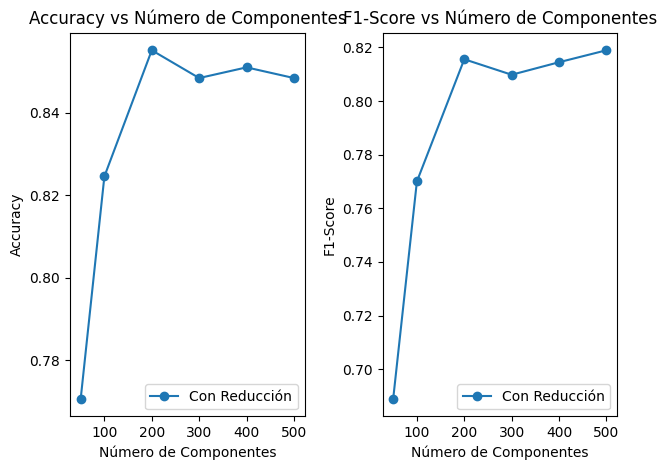

In [ ]:
components = [50, 100, 200, 300, 400, 500]
eval = Evaluator(components)
eval.test_accuracy(Classifier, X_train, X_test, y_train, y_test)
eval.test_f1(Classifier, X_train, X_test, y_train, y_test)
eval.accuracy_plot()

## Conclusiones

Al reducir la dimensionalidad parece que perdermos información crucial que ayuda al modelo a distinguir entre las clases y esto perjudica el rendimiento del modelo, además, originalmente la dimensionalidad es baja por loq ue aprece no haber información irrelevante.


También podemos concluir que al usar otra técnica de vectorización como Word2Vec, el rendimiento disminuye y esto puede ser el resultado de:

- Promedio de vectores: Al promediar los vectores de palabras para obtener esa representación se está perdiendo el orden y eso implica perdida de información.
- Word2Vec sirve para capturar relaciones semánticas generales y en este contexto es necesaria la información expecífica.
- Los datos no son suficientes para crear vectores con Word2Vec representativos.

In [ ]:
%%shell
jupyter nbconvert --to html /content/Microproyecto2_Grupo31.ipynb

[NbConvertApp] Converting notebook /content/Microproyecto2_Grupo31.ipynb to html
[NbConvertApp] Writing 708479 bytes to /content/Microproyecto2_Grupo31.html
